<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/master/notebooks/1g_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perceptrón multicapa


<div style="text-align: right"> Bere et Richardt </div>

---

En esta libreta veremos un ejemplo de clasificación multiclase de imágenes de dígitos implementando un perceptrón multicapa en PyTorch.

Emplearemos un conjunto referencia llamado [MNIST](http://yann.lecun.com/exdb/mnist/) recolectado por [Yann LeCun](http://yann.lecun.com). Está compuesto de imágenes en escala de grises de 28 × 28 píxeles que contienen dígitos entre 0 y 9 escritos a mano. El conjunto cuenta con 60,000 imágenes de entrenamiento y 10,000 de prueba.


![MNIST](../figs/mnist.png)

## 1 Preparación

In [1]:
# Colab
!pip install torch-summary

### 1.1 Bibliotecas

In [2]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# imágenes
from skimage import io
# redes neuronales
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
# inspección de arquitectura
# https://github.com/TylerYep/torch-summary
from torchsummary import summary
# barras de progreso
from tqdm import tqdm

# directorio de datos
DATA_DIR = '../data'

# MNIST
MEAN = (0.1307)
STD = (0.3081)

# tamaño del lote
BATCH_SIZE = 128

# reproducibilidad
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### 1.2 Auxiliares

In [4]:
def display_grid(xs, titles, rows, cols):
    fig, ax = plt.subplots(rows, cols)
    for r in range(rows):
        for c in range(cols):
            i = r * rows + c
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
    fig.tight_layout()
    plt.show()

## 2 Datos

### 2.1 Tuberias de datos con PyTorch

![data](../figs/mlp_datos.png)

### 2.2 Exploración

In [5]:
# creamos un Dataset
ds = MNIST(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=True, 
    # convertir la imagen a ndarray
    transform=np.array, 
    # descargar el conjunto
    download=True
)

images[0] shape=(28, 28) dtype=uint8


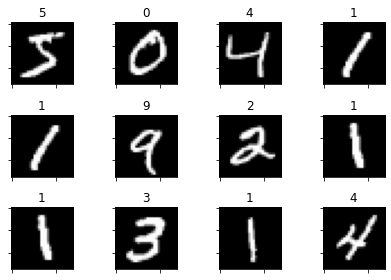

In [6]:
# cargamos algunas imágenes
images, labels = [], []
for i in range(12):
    x, y = ds[i]
    images.append(x)
    labels.append(y)

# desplegamos
print(f'images[0] shape={images[0].shape} dtype={images[0].dtype}')
titles = [str(y) for y in labels]
display_grid(images, titles, 3, 4)

### 2.3 Cargadores de datos

#### Entrenamiento

In [7]:
# transformaciones para la imagen
trn_tsfm = transforms.Compose([
    # convertimos a torch.Tensor y escalamos a [0,1]
    transforms.ToTensor(),
    # estandarizamos: restamos la media y dividimos sobre la varianza
    transforms.Normalize(MEAN, STD),
])

# creamos un Dataset
trn_ds = MNIST(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # transformación
    transform=trn_tsfm
)

# creamos un DataLoader
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
for x, y in take(trn_dl, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([128, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([128]) dtype=torch.int64


#### Prueba

In [8]:
# transformaciones para la imagen
tst_tsfm = transforms.Compose([
    # convertimos a torch.Tensor y escalamos a [0,1]
    transforms.ToTensor(),
    # estandarizamos: restamos la media y dividimos sobre la varianza
    transforms.Normalize(MEAN, STD),
])

# creamos un Dataset
tst_ds = MNIST(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=False,
    # transformación
    transform=tst_tsfm
)

# creamos un DataLoader
tst_dl = DataLoader(
    # subconjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# imprimimos forma y tipo del lote
for x, y in take(tst_dl, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([128, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([128]) dtype=torch.int64


## 3 Modelo

![entrenamiento](../figs/mlp_arquitectura.png)

### 3.1 Definición de la arquitectura

In [9]:
# definición del modelo
class MLP(nn.Module):
    
    # inicializador
    def __init__(self):
        # inicilización del objeto padre, obligatorio
        super(MLP, self).__init__()
        # tamaño de las capas
        self.I = 1 * 28 * 28
        FC1, FC2 = 128, 10
        # definición de capas
        self.cls = nn.Sequential(
            # fc1
            # [N, 1x28x28] => [N, 128]
            nn.Linear(self.I, FC1),
            nn.ReLU(),
            # fc2
            # [N, 128] => [N, 10]
            nn.Linear(FC1, FC2)
        )
    
    # metodo para inferencia
    def forward(self, x):
        # aplanamos los pixeles de la imagen
        # [N, 1, 28, 28] => [N, 1x28x28]
        x = x.view(-1, self.I)
        # inferencia
        # [N, 1x28x28]
        x = self.cls(x)
        return x

### 3.2 Impresión de la arquitectura

In [10]:
model = MLP()
print(model)

MLP(
  (cls): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [11]:
summary(model, (1, 28, 28), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Linear: 2-1                       [-1, 128]                 100,480
|    └─ReLU: 2-2                         [-1, 128]                 --
|    └─Linear: 2-3                       [-1, 10]                  1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (M): 0.20
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.39
Estimated Total Size (MB): 0.39

### 3.3 Prueba de la arquitectura

In [12]:
# inferencia con datos sinteticos
x = torch.zeros(1, 1, 28, 28)
y = model(x)
print(y.shape)

torch.Size([1, 10])


## 4 Entrenamiento

![entrenamiento](../figs/mlp_entrenamiento.png)

### 4.1 Ciclo de entrenamiento

In [13]:
# creamos un modelo
model = MLP()
model.to(device)

# optimizador
opt = optim.SGD(model.parameters(), lr=1e-3)
# historial de pérdida
loss_hist = []

# ciclo de entrenamiento
EPOCHS = 20
for epoch in range(EPOCHS):
    
    # entrenamiento de una época
    for x, y_true in trn_dl:
        x,y_true = x.to(device), y_true.to(device)
        # vaciamos los gradientes
        opt.zero_grad()
        # hacemos inferencia para obtener los logits
        y_lgts = model(x)
        # calculamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad(): 
        # modelo en modo de evaluación
        model.eval()
        
        losses, accs = [], []
        # validación de la época
        for x, y_true in take(tst_dl, 10):
            x,y_true = x.to(device), y_true.to(device)
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # calculamos las probabilidades
            y_prob = F.softmax(y_lgts, 1)
            # obtenemos la clase predicha
            y_pred = torch.argmax(y_prob, 1)
            
            # calculamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)
            # calculamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item() * 100)
            accs.append(acc.item() * 100)

        # imprimimos métricas
        loss = np.mean(losses)
        acc = np.mean(accs)
        print(f'E{epoch:2} loss={loss:6.2f} acc={acc:.2f}')
        
        # agregagmos al historial de pérdidas
        loss_hist.append(loss)
        
        # modelo en modo de entrenamiento
        model.train()

E 0 loss=166.60 acc=69.53
E 1 loss=109.72 acc=79.53
E 2 loss= 76.74 acc=86.25
E 3 loss= 65.12 acc=85.47
E 4 loss= 56.81 acc=87.50
E 5 loss= 48.26 acc=89.45
E 6 loss= 43.22 acc=90.78
E 7 loss= 41.56 acc=89.38
E 8 loss= 44.09 acc=88.20
E 9 loss= 40.88 acc=89.22
E10 loss= 39.50 acc=89.45
E11 loss= 33.93 acc=90.94
E12 loss= 33.12 acc=91.72
E13 loss= 34.02 acc=90.86
E14 loss= 35.27 acc=89.92
E15 loss= 32.29 acc=91.17
E16 loss= 34.69 acc=90.78
E17 loss= 31.92 acc=91.56
E18 loss= 29.94 acc=92.42
E19 loss= 29.59 acc=91.88


### 4.2 Gráfica de la pérdida

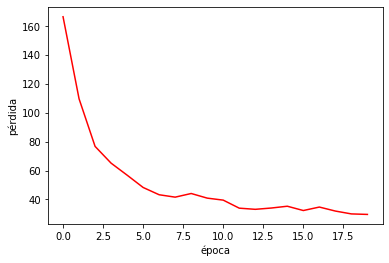

In [14]:
plt.plot(loss_hist, color='red')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

## 5 Evaluación

![eval](https://raw.githubusercontent.com/richardtml/riiaa-20-aa/master/media/eval.jpg)

### 5.1 Conjunto de validación

In [19]:
# modelo en modo de evaluación
model.eval()

# evitamos que se registren las operaciones 
# en la gráfica de cómputo
with torch.no_grad(): 
        
    accs = []
    # validación de la época
    for x, y_true in tst_dl:
        x,y_true = x.to(device), y_true.to(device)
        # hacemos inferencia para obtener los logits
        y_lgts = model(x)
        # calculamos las probabilidades
        y_prob = F.softmax(y_lgts, 1)
        # obtenemos la clase predicha
        y_pred = torch.argmax(y_prob, 1)
        
        # calculamos la exactitud
        x, y_true, y_pred = x.cpu(),y_true.cpu(),y_pred.cpu()
        acc = (y_true == y_pred).type(torch.float32).mean()

        accs.append(acc.item() * 100)

    acc = np.mean(accs)

print(f'Exactitud = {acc:.2f}')

Exactitud = 91.34


### 5.2 Inferencia

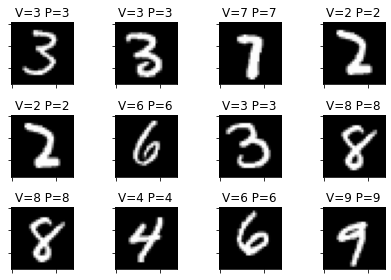

In [20]:
with torch.no_grad(): 
    for x, y_true in take(tst_dl, 1):
        x,y_true = x.to(device), y_true.to(device)
        y_lgts = model(x)
        y_prob = F.softmax(y_lgts, 1)
        y_pred = torch.argmax(y_prob, 1)
        
    x, y_true, y_pred = x.cpu(),y_true.cpu(),y_pred.cpu()
    x = x[:12].squeeze().numpy()
    y_true = y_true[:12].numpy()
    y_pred = y_pred[:12].numpy()

titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
display_grid(x, titles, 3, 4)